#### Funcitons (IGNORE)

In [30]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [31]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [32]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [33]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### MACD Signal

In [34]:
def macd_components(nested_dict,periods,tickers):
    for period in periods:
        for ticker in tickers:
            # get the short and long ema
            nested_dict[period][ticker]['short_ema'] = nested_dict[period][ticker]['Close'].ewm(span=12, adjust=False).mean()
            nested_dict[period][ticker]['long_ema'] = nested_dict[period][ticker]['Close'].ewm(span=26, adjust=False).mean()

            # create the MACD line
            nested_dict[period][ticker]['macd_line'] = nested_dict[period][ticker]['short_ema'] - nested_dict[period][ticker]['long_ema']
            nested_dict[period][ticker]['signal_line'] = nested_dict[period][ticker]['macd_line'].ewm(span=9, adjust=False).mean()

    return nested_dict

In [35]:
def add_macd_signals(nested_dict,periods, tickers, short_window=12, long_window=26, signal_window=9):
    """
    Function to calculate MACD, Signal Line, and generate Buy/Sell/Hold signals based on crossovers.
    """
    for period in periods:
        for ticker in tickers:

            data = nested_dict[period][ticker]

            # Generate 'Buy', 'Sell', 'Hold' signals using np.where() based on crossovers
            data['Signal'] = np.where(data['macd_line'] > data['signal_line'], 'Buy', 
                                    np.where(data['macd_line'] < data['signal_line'], 'Sell', 'Hold'))

In [36]:
def generate_signals(nested_dict, periods, tickers):
    for period in periods:
        for ticker in tickers:
            # Create lists to store buy and sell signals
            buy_signals = []
            sell_signals = []

            # Initialize variables to track the last state (to detect crossovers)
            last_macd_above_signal = None

            # Loop through each row in the MACD dataframe
            for i in range(len(nested_dict[period][ticker]['macd_line'])):
                macd_line = nested_dict[period][ticker]['macd_line'].iloc[i]
                signal_line = nested_dict[period][ticker]['signal_line'].iloc[i]

                # Determine buy/sell signal based on MACD crossover
                if macd_line > signal_line and (last_macd_above_signal is False or last_macd_above_signal is None):
                    buy_signals.append(nested_dict[period][ticker]['Close'].iloc[i])
                    sell_signals.append(None)
                    last_macd_above_signal = True
                elif macd_line < signal_line and (last_macd_above_signal is True or last_macd_above_signal is None):
                    sell_signals.append(nested_dict[period][ticker]['Close'].iloc[i])
                    buy_signals.append(None)
                    last_macd_above_signal = False
                else:
                    # No signal
                    buy_signals.append(None)
                    sell_signals.append(None)

            # Store buy and sell signals in the nested dictionary
            nested_dict[period][ticker]['buy_signals'] = buy_signals
            nested_dict[period][ticker]['sell_signals'] = sell_signals



In [37]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Stochastic Modeling

In [38]:
from datetime import timedelta
def calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=120))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize variables
            account_balance = initial_investment
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: 0 for ticker in tickers}   # Initialize share value for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=120)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=120)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance
                        if account_balance >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance += amount_to_sell

            # Calculate total portfolio value at the end of the period
            portfolio_value = sum(shares_number[ticker] * adj_close_period.iloc[-1][ticker] for ticker in tickers)
            total_value = account_balance + portfolio_value
            
            # Calculate the profit relative to the initial investment
            profit = total_value - initial_investment
            
            # Calculate ROI for each stock as a percentage of the initial investment
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only consider tickers with shares owned
                    roi_dollar_value = shares_value[ticker] - (initial_investment * (percent_to_buy * shares_number[ticker]))

                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

In [39]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Plot data

In [40]:
import matplotlib.pyplot as plt

def plot_macd_signals(macd_data, ticker, title):
    """
    Visualizes MACD Line, Signal Line, and Buy/Sell signals.
    
    Parameters:
    macd_data (pd.DataFrame): DataFrame containing 'Adj Close', 'MACD Line', 'Signal Line', and 'Signal'.
    ticker (str): The stock ticker symbol.
    title (str): Title for the plot.
    """
    # Create subplots: 1 for price, 1 for MACD lines
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot the adjusted close price (price chart)
    ax1.plot(macd_data.index, macd_data['Adj Close'], label=f'{ticker} Price', color='grey')
    ax1.set_title(f'{ticker} Adjusted Close Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Plot the MACD line and Signal line
    ax2.plot(macd_data.index, macd_data['macd_line'], label='MACD Line', color='blue')
    ax2.plot(macd_data.index, macd_data['signal_line'], label='Signal Line', color='red')

    # Mark buy and sell signals
    buy_signals = macd_data[macd_data['Signal'] == 'Buy']
    sell_signals = macd_data[macd_data['Signal'] == 'Sell']
    
    ax2.scatter(buy_signals.index, buy_signals['macd_line'], color='green', marker='^', label='Buy Signal', alpha=1)
    ax2.scatter(sell_signals.index, sell_signals['macd_line'], color='red', marker='v', label='Sell Signal', alpha=1)

    ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Zero line
    ax2.set_title(f'{ticker} MACD and Signal Line')
    ax2.set_ylabel('MACD')
    ax2.legend(loc='upper left')
    
    # Set up x-axis formatting
    plt.xticks(rotation=60)
    plt.xlabel('Date')
    
    plt.tight_layout()
    plt.show()

# Moving Average Convergence Divergence (MACD)
The MACD is another popular technical analysis technique, it concentrates on the momentum of a stock. It has two lines which oscillate between one another. The first line, referred to as the MACD line is found by looking at longer term EMA (typically 26) / shorter term EMA (typically 12). The second line is referred to as the signal line which is typically a 9 day EMA of the MACD line. It can suggest the following:

- Bullish Signal: When the MACD Line crosses above the Signal Line, it can indicate upward momentum, a possible buy signal.
- Bearish Signal: When the MACD Line crosses below the Signal Line, it can indicate downward momentum, a possible sell signal.
- Divergence: Price action diverging from the MACD can signal potential reversals.

In [41]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [42]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [43]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### Moving Average Convergence Divergence Strategy
The MACD technical analysis will create the following parameters:
- Short Exponential Moving Average (12-day)
- Long Exponential Moving Average (26 days)
- MACD Line: The difference between Short EMA and Long EMA
- Signal Line EMA of the MACD line

By utilizing an exponential moving average it gives a greater weight to the more recent values, this makes it more sensitive to recent changes in price. The MACD line measures the convergence or divergence between fast and slow moving averages. When the MACD line is positive (above 0), the short term trend is stronger than the long term trend which suggests an upwards trend. Where as when the MACD line is negative (below 0) the short term is weaker than the long term trend which suggests downwards momentum.

The signal line is used as the buy and sell signal by smoothing the MACD line using a 9 day ema period. When the MACD line goes above the signal line it indicates a buy signal and the MACD line goes below the signal line it indicates a sell signal.


In [44]:
# create the neccessary macd components
macd_components(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)['expansion']['XLB']

,Open,High,Low,Close,Adj Close,Volume,short_ema,long_ema,macd_line,signal_line
Date,,,,,,,,,,
2012-01-03,34.240002,34.590000,34.230000,34.430000,26.488379,11213800,34.430000,34.430000,0.000000,0.000000
2012-01-04,34.389999,34.750000,34.250000,34.720001,26.711496,8772400,34.474616,34.451482,0.023134,0.004627
2012-01-05,34.419998,34.950001,34.320000,34.820000,26.788425,7783700,34.527752,34.478779,0.048972,0.013496
2012-01-06,34.700001,34.889999,34.549999,34.770000,26.749960,7218700,34.565021,34.500351,0.064669,0.023731
2012-01-09,34.820000,34.970001,34.680000,34.840000,26.803804,9204600,34.607325,34.525511,0.081815,0.035347
...,...,...,...,...,...,...,...,...,...,...
2014-12-24,49.049999,49.240002,48.980000,49.060001,40.311287,1878800,48.511137,48.600054,-0.088917,-0.192652
2014-12-26,49.360001,49.389999,49.160000,49.230000,40.450970,1297000,48.621731,48.646716,-0.024985,-0.159119
2014-12-29,49.110001,49.369999,49.110001,49.230000,40.450970,2173200,48.715311,48.689923,0.025388,-0.122218


In [45]:
add_macd_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

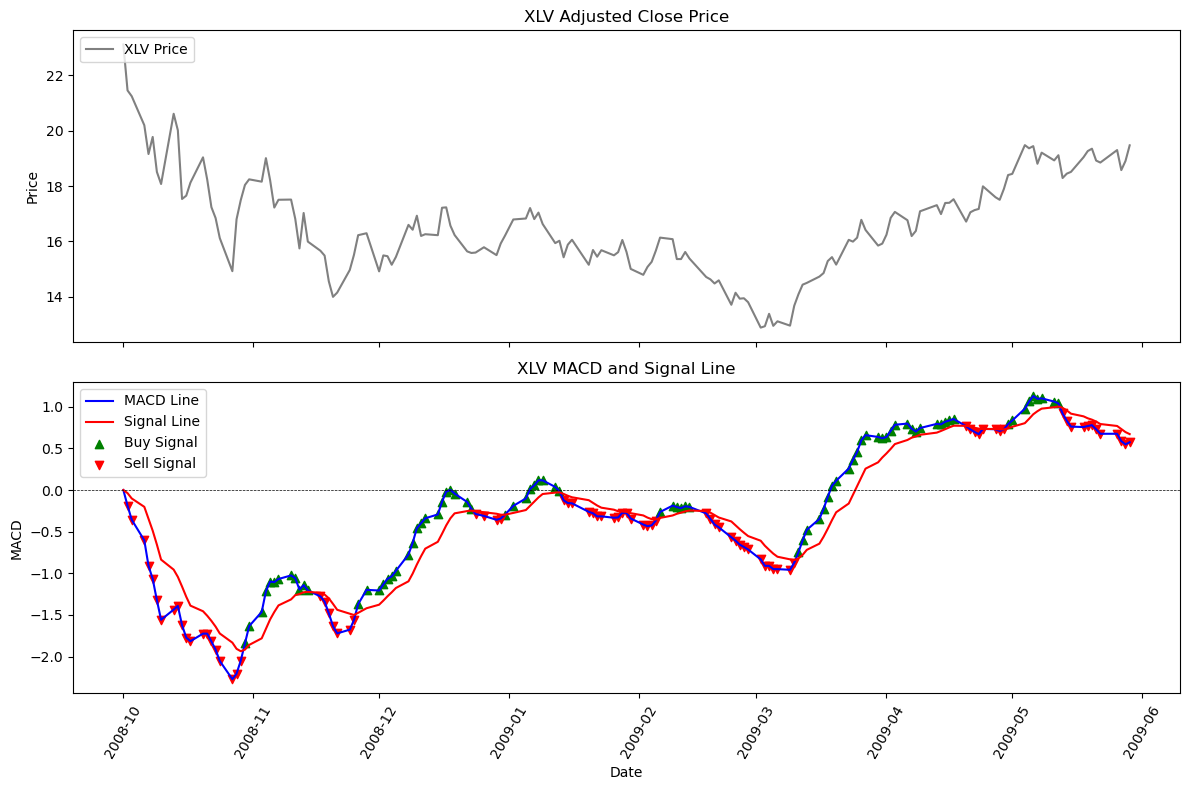

In [46]:
# plot the macd lines 
plot_macd_signals(sector_etf_data['trough']['XLB'], 'XLV', 'MACD for XLV during trough')

In [47]:
sector_etf_data['expansion']['XLV']['Signal'].value_counts()

Buy     386
Sell    367
Hold      1
Name: Signal, dtype: int64

In [48]:
macd_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [49]:
for period in economic_cycle_periods_list:
    macd_signals[period].to_csv(f'/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/signal_data/macd_signals/{period}_macd_signal.csv')

In [50]:
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [51]:
macd_investment = calculate_stock_roi(macd_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,100,100,0.05,0.05)

In [52]:
macd_baseline_model = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,macd_investment,'Mean')
macd_baseline_model

,trough,expansion,peak,contraction,all_data
XLB,2.464467,4.805908,5.191349,2.273107,4.517881
XLI,1.181829,4.373775,4.607471,3.805101,4.155798
XLF,-1.375669,2.658559,4.127475,1.586218,3.21892
XLK,3.234534,4.870575,7.196871,5.22259,5.135062
XLY,2.211401,5.129652,7.454653,3.407976,4.352046
XLP,1.604258,5.14367,5.596473,3.593887,4.886727
XLE,5.097197,4.754781,2.765342,3.434306,6.427115
XLV,4.069704,5.102541,7.527814,6.436785,5.074321
VOX,2.589499,6.290596,5.215042,3.267746,5.562711
XLU,4.636103,7.167584,7.509562,3.627477,6.123828


In [59]:
macd_baseline_model.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/macd/macd_baseline.csv')

In [53]:
macd_baseline_model.mean()

trough         2.428706
expansion      5.327136
peak           5.747814
contraction    3.585840
all_data       4.934069
dtype: float64